In [10]:
import pandas as pd
import json
import numpy as np
from collections import Counter
import re
import os

### SPARK

In [11]:
!pip install geopandas
!pip install osmnx geopandas
!pip install scipy scikit-learn
!pip install pyspark
!pip install pyarrow
!pip install matplotlib
!pip install seaborn	

In [12]:
import geopandas as gpd
import pandas as pd

# Vérifier si le fichier existe déjà
output_file = 'data_coord/clusters-rouges.csv'
if os.path.exists(output_file):
    print(f"✓ Le fichier '{output_file}' existe déjà, chargement...")
    df_clusters = pd.read_csv(output_file)
    print(f"  {len(df_clusters)} lignes chargées")
    display(df_clusters.head())
else:
    print(f"Création du fichier '{output_file}'...")
    # Lire le fichier GeoJSON
    gdf_clusters = gpd.read_file('data_coord/clusters-rouges-200046977.geojson')

    # Extraire les propriétés et coordonnées du centroid
    df_clusters = pd.DataFrame(gdf_clusters.drop(columns='geometry'))
    df_clusters['longitude'] = gdf_clusters.geometry.centroid.x
    df_clusters['latitude'] = gdf_clusters.geometry.centroid.y

    # Exporter en CSV
    df_clusters.to_csv(output_file, index=False)
    print(f"Fichier '{output_file}' créé avec {len(df_clusters)} lignes")
    display(df_clusters.head())

✓ Le fichier 'data_coord/clusters-rouges.csv' existe déjà, chargement...
  164 lignes chargées


,uid,insee,cat,nb_points,taux_points,longitude,latitude
0,1928af76-3a27-4bb5-82bb-008f4b9b3e86,69199,58,24,64.86,4.854812,45.716985
1,1eca17ef-9918-4bf9-8538-6483192bcd51,69266,58,179,8.69,4.905975,45.769277
2,0b7b0a92-d58f-4977-a3eb-8a3fee9c15ba,69266,58,286,13.88,4.882567,45.768935
3,7344fd97-e04c-4f58-94e1-3f9be8129a90,69388,58,78,17.45,4.860312,45.749487
4,04b1ae46-0b6b-4e2f-b5a5-b97055ce0b37,69081,58,228,131.79,4.793206,45.773931


In [13]:
import osmnx as ox
import geopandas as gpd
import pandas as pd

output_file = 'data_coord/clusters-rouges.csv'
if os.path.exists(output_file):
    print(f"✓ Le fichier '{output_file}' existe déjà, chargement...")
else :
    # Charger le réseau routier de Lyon
    G = ox.graph_from_place("Lyon, France", network_type="drive")

    # Projeter le graphe en mètres (UTM) pour un calcul de distance précis
    G_proj = ox.project_graph(G)

    # Préparer les données - convertir en centroids pour avoir des Points
    gdf_proj = gdf_clusters.to_crs(G_proj.graph['crs'])
    centroids_proj = gdf_proj.geometry.centroid

    # Trouver l'arête (rue) la plus proche pour chaque centroid
    nearest_edges = ox.nearest_edges(G_proj, X=centroids_proj.x, Y=centroids_proj.y)

    # Calculer le point exact sur la rue (projection orthogonale)
    edges = ox.graph_to_gdfs(G_proj, nodes=False)
    projected_points = []

    for i, (centroid, edge_id) in enumerate(zip(centroids_proj, nearest_edges)):
        # Récupérer la ligne (geometry) de la rue correspondante
        street_line = edges.loc[edge_id, 'geometry']
        # Trouver le point sur cette ligne le plus proche du centroid
        snap_point = street_line.interpolate(street_line.project(centroid))
        projected_points.append(snap_point)

    # Créer un GeoDataFrame temporaire pour convertir les points projetés en Lat/Lon
    snapped_gdf = gpd.GeoDataFrame(geometry=projected_points, crs=G_proj.graph['crs'])
    snapped_gdf = snapped_gdf.to_crs(epsg=4326)

    # Ajouter les colonnes au DataFrame d'origine
    gdf_clusters['longitude_modified'] = snapped_gdf.geometry.x
    gdf_clusters['latitude_modified'] = snapped_gdf.geometry.y

    # Affichage des résultats
    display(gdf_clusters[['longitude_modified', 'latitude_modified']].head())

✓ Le fichier 'data_coord/clusters-rouges.csv' existe déjà, chargement...


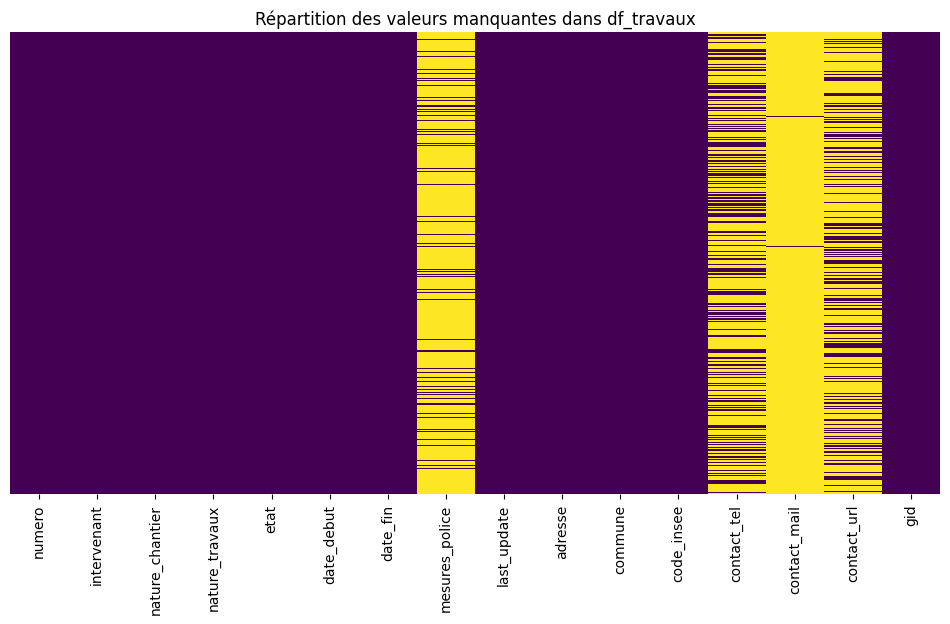

In [14]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
# Charger le dataframe du dataset des travaux engagés à Lyon
df_travaux = pd.read_csv("data_travaux/travaux-engages-metropole-lyon.csv", sep=";")
# Visualisation des valeurs manquantes dans df_travaux
plt.figure(figsize=(12, 6))
sns.heatmap(df_travaux.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Répartition des valeurs manquantes dans df_travaux')
plt.show()

In [15]:
cols_travaux_a_supprimer = ['mesures_police', 'contact_tel', 'contact_mail', 'contact_url'] # Trop de NaN dans les colonnes
df_travaux = df_travaux.drop(columns=cols_travaux_a_supprimer, errors='ignore')

In [16]:
print("--- Valeurs manquantes dans df_travaux ---")
print(df_travaux.isnull().sum())

# Supprime les lignes où 'date_debut' est NaN
df_travaux = df_travaux.dropna(subset=['date_debut'])

--- Valeurs manquantes dans df_travaux ---
numero             0
intervenant        0
nature_chantier    0
nature_travaux     0
etat               0
date_debut         3
date_fin           0
last_update        0
adresse            0
commune            0
code_insee         0
gid                0
dtype: int64


In [17]:
df_flux = pd.read_csv("data_flux/mesures-comptage-metropole-lyon.csv", sep=';')


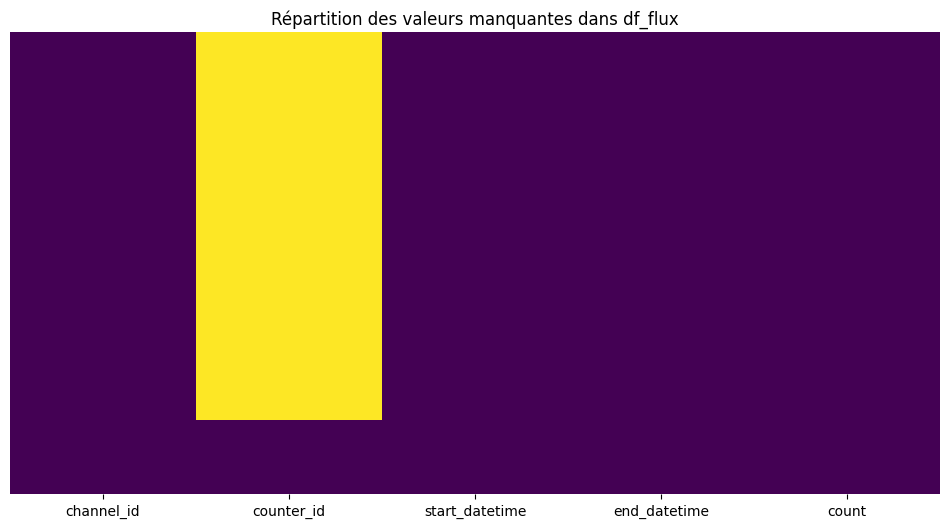

In [18]:
# Visualisation des valeurs manquantes dans df_flux
plt.figure(figsize=(12, 6))
sns.heatmap(df_flux.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Répartition des valeurs manquantes dans df_flux')
plt.show()

In [19]:
# Suppression de la colonne 'counter_id' 
df_flux = df_flux.drop(columns="counter_id", errors='ignore')

In [20]:
# Charger les données de flux détaillées
df_mesure_flux = pd.read_csv("data_flux/mesure_flux.csv", sep=';')

# Suppression de la colonne 'counter_id' et filtrage des valeurs > 0
df_mesure_flux = df_mesure_flux.drop(columns="counter_id", errors='ignore')
df_mesure_flux = df_mesure_flux[df_mesure_flux['count'] > 0]

print(f"Données de mesure flux: {len(df_mesure_flux)} lignes")
display(df_mesure_flux.head())

Données de mesure flux: 864 lignes


,channel_id,start_datetime,end_datetime,count
3,100029813,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00,1
5,100029813,2023-04-05 20:00:00+02:00,2023-04-05 21:00:00+02:00,6
6,100029813,2023-04-05 19:00:00+02:00,2023-04-05 20:00:00+02:00,37
7,100029813,2023-04-05 18:00:00+02:00,2023-04-05 19:00:00+02:00,80
8,100029813,2023-04-05 17:00:00+02:00,2023-04-05 18:00:00+02:00,90


In [21]:
import pandas as pd
import geopandas as gpd

# Chargement des référentiels
df_channels_flux = pd.read_csv("./data_flux/channels_flux.csv", sep=";")
df_channels_flux = df_channels_flux[df_channels_flux['mobility_type'] == 'BIKE']
gdf_sites_flux = gpd.read_file("./data_flux/sites_flux.json")

# Harmonisation des types
df_mesure_flux['channel_id'] = df_mesure_flux['channel_id'].astype(str)
df_channels_flux['channel_id'] = df_channels_flux['channel_id'].astype(str)
df_channels_flux['site_id'] = df_channels_flux['site_id'].astype(str)
gdf_sites_flux['site_id'] = gdf_sites_flux['site_id'].astype(str)

# Fusion des données
df_intermediaire = pd.merge(
    df_mesure_flux, 
    df_channels_flux[['channel_id', 'site_id']], 
    on='channel_id', 
    how='inner'
)

gdf_final = gdf_sites_flux.merge(df_intermediaire, on='site_id', how='inner')

print(f"Fusion réussie ! Nombre de lignes finales : {len(gdf_final)}")
display(gdf_final.head())

Fusion réussie ! Nombre de lignes finales : 756


,id,gid,site_id,parent_site_id,fr_insee_code,xlong,ylat,external_ids,infrastructure_type,site_name,geometry,channel_id,start_datetime,end_datetime,count
0,pvo_patrimoine_voirie.pvocomptagesite.100013842,100013842,100013842,,69123,4.821243,45.732002,,,Lyon 7_Pont Raymond Barre,POINT (4.82124 45.732),101013842,2023-04-06 01:00:00+02:00,2023-04-06 02:00:00+02:00,2
1,pvo_patrimoine_voirie.pvocomptagesite.100013842,100013842,100013842,,69123,4.821243,45.732002,,,Lyon 7_Pont Raymond Barre,POINT (4.82124 45.732),101013842,2023-04-06 00:00:00+02:00,2023-04-06 01:00:00+02:00,6
2,pvo_patrimoine_voirie.pvocomptagesite.100013842,100013842,100013842,,69123,4.821243,45.732002,,,Lyon 7_Pont Raymond Barre,POINT (4.82124 45.732),101013842,2023-04-05 23:00:00+02:00,2023-04-06 00:00:00+02:00,21
3,pvo_patrimoine_voirie.pvocomptagesite.100013842,100013842,100013842,,69123,4.821243,45.732002,,,Lyon 7_Pont Raymond Barre,POINT (4.82124 45.732),101013842,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00,18
4,pvo_patrimoine_voirie.pvocomptagesite.100013842,100013842,100013842,,69123,4.821243,45.732002,,,Lyon 7_Pont Raymond Barre,POINT (4.82124 45.732),101013842,2023-04-05 21:00:00+02:00,2023-04-05 22:00:00+02:00,28


In [22]:
# Sélection des colonnes essentielles
colonnes_a_garder = [
    'geometry', 
    'site_name', 
    'count', 
    'start_datetime', 
    'end_datetime'
]

gdf_final_clean = gdf_final[colonnes_a_garder].copy()

# Formater les dates
gdf_final_clean['start_datetime'] = pd.to_datetime(gdf_final_clean['start_datetime'])
gdf_final_clean['end_datetime'] = pd.to_datetime(gdf_final_clean['end_datetime'])

print("Dataset final optimisé :")
display(gdf_final_clean.head())

Dataset final optimisé :


,geometry,site_name,count,start_datetime,end_datetime
0,POINT (4.82124 45.732),Lyon 7_Pont Raymond Barre,2,2023-04-06 01:00:00+02:00,2023-04-06 02:00:00+02:00
1,POINT (4.82124 45.732),Lyon 7_Pont Raymond Barre,6,2023-04-06 00:00:00+02:00,2023-04-06 01:00:00+02:00
2,POINT (4.82124 45.732),Lyon 7_Pont Raymond Barre,21,2023-04-05 23:00:00+02:00,2023-04-06 00:00:00+02:00
3,POINT (4.82124 45.732),Lyon 7_Pont Raymond Barre,18,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00
4,POINT (4.82124 45.732),Lyon 7_Pont Raymond Barre,28,2023-04-05 21:00:00+02:00,2023-04-05 22:00:00+02:00


In [23]:
# Vérifier si le fichier existe déjà
output_file = "data_flux_final/comptages_flux.csv"
if os.path.exists(output_file):
    print(f"✓ Le fichier '{output_file}' existe déjà, skip de la génération.")
else:
    print(f"Création du fichier '{output_file}'...")
    # Extraire latitude et longitude de la géométrie
    gdf_final_clean['longitude'] = gdf_final_clean.geometry.x
    gdf_final_clean['latitude'] = gdf_final_clean.geometry.y

    # Exporter en CSV
    gdf_final_clean.drop(columns=['geometry']).to_csv(output_file, index=False, sep=";")
    print(f"Le fichier '{output_file}' a été généré avec succès.")

✓ Le fichier 'data_flux_final/comptages_flux.csv' existe déjà, skip de la génération.


In [24]:
import pandas as pd
import requests
import os

# Vérifier si le fichier existe déjà
output_file = "data_flux_final/comptages_villeavelo_final.csv"
if os.path.exists(output_file):
    print(f"✓ Le fichier '{output_file}' existe déjà, chargement...")
    df_final_villeavelo = pd.read_csv(output_file, sep=";")
    print(f"  {len(df_final_villeavelo)} lignes chargées")
    display(df_final_villeavelo.head())
else:
    print(f"Création du fichier '{output_file}'...")
    
    # Chargement des données villeavelo
    df_villavelo = pd.read_csv("./data_flux/comptage_villeavelo.csv", sep=";")

    # Nettoyer les NaN dans les colonnes importantes
    df_villavelo = df_villavelo.dropna(subset=['Adresse', 'Date', 'Heure début', 'Heure fin', 'Nombre comptés'])

    def geocode_adresse(adresse):
        """Interroge l'API Adresse du gouvernement français."""
        url = "https://api-adresse.data.gouv.fr/search/"
        params = {'q': f"{adresse}, Lyon", 'limit': 1}
        try:
            response = requests.get(url, params=params, timeout=5)
            data = response.json()
            if data['features']:
                lon, lat = data['features'][0]['geometry']['coordinates']
                return lat, lon
        except Exception as e:
            print(f"Erreur pour l'adresse {adresse}: {e}")
        return None, None

    # Géocodage
    print(f"Géocodage en cours pour {len(df_villavelo)} adresses...")
    coords = df_villavelo['Adresse'].apply(geocode_adresse)
    df_villavelo[['latitude', 'longitude']] = pd.DataFrame(coords.tolist(), index=df_villavelo.index)

    # Transformation au format final
    df_final_villeavelo = pd.DataFrame()
    df_final_villeavelo['Adresse'] = df_villavelo['Adresse']
    df_final_villeavelo['count'] = df_villavelo['Nombre comptés']

    # Conversion des dates avec gestion d'erreur
    try:
        df_final_villeavelo['start_datetime'] = pd.to_datetime(
            df_villavelo['Date'] + ' ' + df_villavelo['Heure début'], 
            dayfirst=True,
            errors='coerce'
        )
        df_final_villeavelo['end_datetime'] = pd.to_datetime(
            df_villavelo['Date'] + ' ' + df_villavelo['Heure fin'], 
            dayfirst=True,
            errors='coerce'
        )
    except Exception as e:
        print(f"Erreur lors de la conversion des dates: {e}")

    df_final_villeavelo['longitude'] = df_villavelo['longitude']
    df_final_villeavelo['latitude'] = df_villavelo['latitude']

    # Nettoyage final
    df_final_villeavelo = df_final_villeavelo.dropna(subset=['latitude', 'start_datetime', 'end_datetime'])

    # Exporter df_final_villeavelo en CSV
    df_final_villeavelo.to_csv(output_file, index=False, sep=";")
    print(f"Traitement villeavelo terminé: {len(df_final_villeavelo)} lignes valides")
    print(f"Fichier '{output_file}' créé avec succès")
    print(f"Colonnes: {list(df_final_villeavelo.columns)}")
    display(df_final_villeavelo.head())

✓ Le fichier 'data_flux_final/comptages_villeavelo_final.csv' existe déjà, chargement...
  1766 lignes chargées


,Adresse,count,start_datetime,end_datetime,longitude,latitude
0,Avenue des Cottages,135.0,2024-12-03 07:30:00,2024-12-03 09:00:00,2.811628,48.377262
1,Avenue des Cottages,7.0,2024-12-03 07:30:00,2024-12-03 09:00:00,2.811628,48.377262
2,Avenue des Cottages,25.0,2024-12-03 07:30:00,2024-12-03 09:00:00,2.811628,48.377262
3,Avenue des Cottages,5.0,2024-12-03 07:30:00,2024-12-03 09:00:00,2.811628,48.377262
4,Avenue des Cottages,43.0,2024-12-03 07:30:00,2024-12-03 09:00:00,2.811628,48.377262


# Priorisation des Problèmes selon les Flux de Passage

**Objectif:** Créer une échelle d'importance des problèmes basée sur les flux cyclables.

**Logique:**
- Problème avec **flux élevé** = Priorité HAUTE (impact sur beaucoup de cyclistes)
- Problème avec **flux moyen** = Priorité MOYENNE
- Problème avec **flux faible** = Priorité BASSE

In [25]:
# Chargement des incidents catégorisés
incidents = pd.read_csv('resultats_croisement_complet/points_rouges_sans_travaux_traite.csv', encoding='utf-8-sig')
print(f"Incidents catégorisés chargés: {len(incidents)} lignes")
print(f"Colonnes: {list(incidents.columns)}")
incidents.head()

Incidents catégorisés chargés: 20643 lignes
Colonnes: ['longitude', 'latitude', 'commune_insee', 'description', 'categorie_detectee', 'score_urgence', 'score_facilite', 'niveau_facilite_label']


,longitude,latitude,commune_insee,description,categorie_detectee,score_urgence,score_facilite,niveau_facilite_label
0,4.765324,45.729969,69089,"Forte pente, route très étroite",Aménagement inadapté,2,1,🟢 Facile (Quick Win)
1,4.834041,45.844900,69168,Pont étroit,Aménagement inadapté,2,1,🟢 Facile (Quick Win)
2,4.860460,45.749430,69123,Virage à gauche en direction de la manufacture...,Aménagement inadapté,2,1,🟢 Facile (Quick Win)
3,4.882602,45.707046,69259,"pas de piste cyclable (rue étroite) , les voit...",Aménagement inadapté,2,1,🟢 Facile (Quick Win)
4,4.871354,45.763522,69266,Rue étroite,Aménagement inadapté,2,1,🟢 Facile (Quick Win)


In [26]:
# Chargement des flux officiels
flux_officiels = pd.read_csv('data_flux_final/comptages_flux.csv', sep=';')
print(f"Flux officiels: {len(flux_officiels)} lignes")

# Chargement des flux participatifs VillaVelo
flux_villeavelo = pd.read_csv('data_flux_final/comptages_villeavelo_final.csv', sep=';')
print(f"Flux VillaVelo: {len(flux_villeavelo)} lignes")

flux_officiels.head()

Flux officiels: 756 lignes
Flux VillaVelo: 1766 lignes


,site_name,count,start_datetime,end_datetime,longitude,latitude
0,Lyon 7_Pont Raymond Barre,2,2023-04-06 01:00:00+02:00,2023-04-06 02:00:00+02:00,4.821243,45.732002
1,Lyon 7_Pont Raymond Barre,6,2023-04-06 00:00:00+02:00,2023-04-06 01:00:00+02:00,4.821243,45.732002
2,Lyon 7_Pont Raymond Barre,21,2023-04-05 23:00:00+02:00,2023-04-06 00:00:00+02:00,4.821243,45.732002
3,Lyon 7_Pont Raymond Barre,18,2023-04-05 22:00:00+02:00,2023-04-05 23:00:00+02:00,4.821243,45.732002
4,Lyon 7_Pont Raymond Barre,28,2023-04-05 21:00:00+02:00,2023-04-05 22:00:00+02:00,4.821243,45.732002


## 1. Agrégation des Flux par Position Géographique

In [27]:
# Agrégation flux officiels : somme des comptages par site
flux_officiels_agg = flux_officiels.groupby(['site_name', 'longitude', 'latitude']).agg({
    'count': 'sum'
}).reset_index()
flux_officiels_agg.rename(columns={'site_name': 'location', 'count': 'total_flux'}, inplace=True)

print(f"Flux officiels agrégés: {len(flux_officiels_agg)} sites uniques")
print(f"Flux total officiel: {flux_officiels_agg['total_flux'].sum():,.0f} passages")
flux_officiels_agg.head()

Flux officiels agrégés: 6 sites uniques
Flux total officiel: 32,228 passages


,location,longitude,latitude,total_flux
0,Lyon 1_Pont la Feuillée EO corrigé,4.830009,45.766740,11800
1,Lyon 1_Pont la Feuillée OE corrigé,4.830000,45.766754,8273
2,Lyon 7_Pont Raymond Barre,4.821243,45.732002,8884
3,Lyon 7_Pont de l'Université EO corrigé,4.836061,45.752243,1354
4,Lyon 7_Pont de l'Université OE corrigé,4.836061,45.752243,1905


In [28]:
# Agrégation flux participatifs : somme des comptages par adresse
flux_villeavelo_agg = flux_villeavelo.groupby(['Adresse', 'longitude', 'latitude']).agg({
    'count': 'sum'
}).reset_index()
flux_villeavelo_agg.rename(columns={'Adresse': 'location', 'count': 'total_flux'}, inplace=True)

print(f"Flux VillaVelo agrégés: {len(flux_villeavelo_agg)} adresses uniques")
print(f"Flux total VillaVelo: {flux_villeavelo_agg['total_flux'].sum():,.0f} passages")
flux_villeavelo_agg.head()

Flux VillaVelo agrégés: 18 adresses uniques
Flux total VillaVelo: 22,553 passages


,location,longitude,latitude,total_flux
0,Avenue des Cottages,2.811628,48.377262,522.0
1,Bas Montée Bonnafous,4.837716,45.774843,59.0
2,Bas Montée St Sébastien,4.835058,45.772192,1463.0
3,Bas Montée des Forts,4.832572,45.793637,319.0
4,Bvd des Canuts,4.828003,45.778990,4620.0


In [29]:
# Fusion des deux sources de flux
flux_total = pd.concat([flux_officiels_agg, flux_villeavelo_agg], ignore_index=True)

print(f"Flux total combiné: {len(flux_total)} points de comptage")
print(f"Flux cumulé: {flux_total['total_flux'].sum():,.0f} passages")
print(f"\nStatistiques des flux:")
print(flux_total['total_flux'].describe())

Flux total combiné: 24 points de comptage
Flux cumulé: 54,781 passages

Statistiques des flux:
count       24.000000
mean      2282.541667
std       3227.422231
min         12.000000
25%        196.000000
50%       1050.500000
75%       2126.500000
max      11800.000000
Name: total_flux, dtype: float64


## 2. Fonction de Distance Haversine

Calcule la distance entre deux points GPS (en mètres)

In [30]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcule la distance en mètres entre deux points GPS.
    """
    R = 6371000  # Rayon de la Terre en mètres
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    
    return distance

# Test de la fonction
test_dist = haversine_distance(45.75, 4.85, 45.76, 4.86)
print(f"Distance test (45.75,4.85) -> (45.76,4.86): {test_dist:.0f} mètres")

Distance test (45.75,4.85) -> (45.76,4.86): 1356 mètres


## 3. Croisement Spatial: Trouver le Flux le Plus Proche

Pour chaque incident, on cherche le point de comptage le plus proche et on récupère son flux.

In [31]:
def find_nearest_flux(incident_lat, incident_lon, flux_df):
    """
    Trouve le point de flux le plus proche d'un incident.
    Retourne: (distance_min, flux_total, location)
    """
    distances = []
    
    for idx, row in flux_df.iterrows():
        dist = haversine_distance(
            incident_lat, incident_lon,
            row['latitude'], row['longitude']
        )
        distances.append((dist, row['total_flux'], row['location']))
    
    # Trouver le minimum
    min_dist, flux, location = min(distances, key=lambda x: x[0])
    return min_dist, flux, location

print("Fonction de recherche du flux le plus proche créée.")

Fonction de recherche du flux le plus proche créée.


In [32]:
# Application du croisement spatial sur tous les incidents
print("Croisement en cours... (peut prendre quelques minutes)")

resultats = []
for idx, incident in incidents.iterrows():
    if idx % 100 == 0:
        print(f"Traitement: {idx}/{len(incidents)}...")
    
    dist, flux, location = find_nearest_flux(
        incident['latitude'], 
        incident['longitude'], 
        flux_total
    )
    
    resultats.append({
        'distance_flux_m': dist,
        'flux_proche': flux,
        'location_flux': location
    })

# Ajout des colonnes au DataFrame
resultats_df = pd.DataFrame(resultats)
incidents_flux = pd.concat([incidents, resultats_df], axis=1)

print(f"\nCroisement terminé!")
print(f"Distance moyenne au point de flux: {incidents_flux['distance_flux_m'].mean():.0f} m")
print(f"Distance médiane: {incidents_flux['distance_flux_m'].median():.0f} m")
incidents_flux.head()

Croisement en cours... (peut prendre quelques minutes)
Traitement: 0/20643...
Traitement: 100/20643...
Traitement: 200/20643...
Traitement: 300/20643...
Traitement: 400/20643...
Traitement: 500/20643...
Traitement: 600/20643...
Traitement: 700/20643...
Traitement: 800/20643...
Traitement: 900/20643...
Traitement: 1000/20643...
Traitement: 1100/20643...
Traitement: 1200/20643...
Traitement: 1300/20643...
Traitement: 1400/20643...
Traitement: 1500/20643...
Traitement: 1600/20643...
Traitement: 1700/20643...
Traitement: 1800/20643...
Traitement: 1900/20643...
Traitement: 2000/20643...
Traitement: 2100/20643...
Traitement: 2200/20643...
Traitement: 2300/20643...
Traitement: 2400/20643...
Traitement: 2500/20643...
Traitement: 2600/20643...
Traitement: 2700/20643...
Traitement: 2800/20643...
Traitement: 2900/20643...
Traitement: 3000/20643...
Traitement: 3100/20643...
Traitement: 3200/20643...
Traitement: 3300/20643...
Traitement: 3400/20643...
Traitement: 3500/20643...
Traitement: 3600/2064

,longitude,latitude,commune_insee,description,categorie_detectee,score_urgence,score_facilite,niveau_facilite_label,distance_flux_m,flux_proche,location_flux
0,4.765324,45.729969,69089,"Forte pente, route très étroite",Aménagement inadapté,2,1,🟢 Facile (Quick Win),4247.835550,1918.0,Maison de la Voie Verte
1,4.834041,45.844900,69168,Pont étroit,Aménagement inadapté,2,1,🟢 Facile (Quick Win),4011.513744,154.0,Montée Sathonay Village
2,4.860460,45.749430,69123,Virage à gauche en direction de la manufacture...,Aménagement inadapté,2,1,🟢 Facile (Quick Win),1918.770065,1354.0,Lyon 7_Pont de l'Université EO corrigé
3,4.882602,45.707046,69259,"pas de piste cyclable (rue étroite) , les voit...",Aménagement inadapté,2,1,🟢 Facile (Quick Win),5512.845045,8884.0,Lyon 7_Pont Raymond Barre
4,4.871354,45.763522,69266,Rue étroite,Aménagement inadapté,2,1,🟢 Facile (Quick Win),2864.360045,1439.0,Passerelle de la Paix


## 4. Création de l'Échelle d'Importance

Basée sur les quartiles de flux :
- **CRITIQUE** (🔴): Flux > 75e percentile + Distance < 500m
- **ÉLEVÉE** (🟠): Flux > 50e percentile
- **MOYENNE** (🟡): Flux > 25e percentile
- **FAIBLE** (🟢): Flux <= 25e percentile

In [33]:
# Calcul des seuils de flux (quartiles)
q25 = incidents_flux['flux_proche'].quantile(0.25)
q50 = incidents_flux['flux_proche'].quantile(0.50)
q75 = incidents_flux['flux_proche'].quantile(0.75)
q90 = incidents_flux['flux_proche'].quantile(0.90)

print(f"Seuils de flux calculés:")
print(f"  25e percentile: {q25:,.0f} passages")
print(f"  50e percentile (médiane): {q50:,.0f} passages")
print(f"  75e percentile: {q75:,.0f} passages")
print(f"  90e percentile: {q90:,.0f} passages")

Seuils de flux calculés:
  25e percentile: 133 passages
  50e percentile (médiane): 1,354 passages
  75e percentile: 1,463 passages
  90e percentile: 8,884 passages


In [34]:
def calculer_priorite(row):
    """
    Calcule la priorité basée sur le flux et la distance.
    """
    flux = row['flux_proche']
    distance = row['distance_flux_m']
    
    # Priorité CRITIQUE : flux très élevé ET proche d'un compteur
    if flux >= q90 and distance < 500:
        return 'CRITIQUE', 4, '🔴'
    # Priorité ÉLEVÉE : flux élevé
    elif flux >= q75:
        return 'ÉLEVÉE', 3, '🟠'
    # Priorité MOYENNE : flux moyen
    elif flux >= q50:
        return 'MOYENNE', 2, '🟡'
    # Priorité FAIBLE : flux faible
    else:
        return 'FAIBLE', 1, '🟢'

# Application de la fonction
incidents_flux[['priorite_label', 'priorite_score', 'priorite_emoji']] = incidents_flux.apply(
    calculer_priorite, axis=1, result_type='expand'
)

print("\nÉchelle de priorité appliquée!")
print("\nRépartition des priorités:")
print(incidents_flux['priorite_label'].value_counts().sort_index())


Échelle de priorité appliquée!

Répartition des priorités:
priorite_label
CRITIQUE     376
FAIBLE      7220
MOYENNE     7837
ÉLEVÉE      5210
Name: count, dtype: int64


## 5. Calcul du Score Global d'Importance

Combine plusieurs facteurs:
- **Flux** (pondération 40%)
- **Score d'urgence** existant (pondération 30%)
- **Proximité au compteur** (pondération 20%)
- **Score de facilité** (pondération 10%)

In [35]:
# Normalisation des variables (0-100)
incidents_flux['flux_normalized'] = (
    (incidents_flux['flux_proche'] - incidents_flux['flux_proche'].min()) / 
    (incidents_flux['flux_proche'].max() - incidents_flux['flux_proche'].min())
) * 100

# Proximité inversée (plus c'est proche, mieux c'est)
incidents_flux['proximite_normalized'] = (
    100 - ((incidents_flux['distance_flux_m'] - incidents_flux['distance_flux_m'].min()) / 
    (incidents_flux['distance_flux_m'].max() - incidents_flux['distance_flux_m'].min())) * 100
)

# Score d'urgence normalisé (on suppose que c'est sur une échelle de 1-3)
incidents_flux['urgence_normalized'] = (incidents_flux['score_urgence'] / 3) * 100

# Score de facilité normalisé
incidents_flux['facilite_normalized'] = (incidents_flux['score_facilite'] / 3) * 100

# Calcul du score global pondéré
incidents_flux['score_importance_global'] = (
    incidents_flux['flux_normalized'] * 0.40 +
    incidents_flux['urgence_normalized'] * 0.30 +
    incidents_flux['proximite_normalized'] * 0.20 +
    incidents_flux['facilite_normalized'] * 0.10
).round(2)

print("Score global d'importance calculé!")
print(f"\nScore min: {incidents_flux['score_importance_global'].min():.2f}")
print(f"Score max: {incidents_flux['score_importance_global'].max():.2f}")
print(f"Score moyen: {incidents_flux['score_importance_global'].mean():.2f}")

Score global d'importance calculé!

Score min: 19.21
Score max: 100.00
Score moyen: 56.02


## 6. Analyse et Visualisation

In [37]:
# Top 20 problèmes les plus importants
top_problemes = incidents_flux.nlargest(20, 'score_importance_global')[[
    'commune_insee', 'description', 'categorie_detectee', 
    'flux_proche', 'distance_flux_m', 'location_flux',
    'priorite_emoji', 'priorite_label', 'score_importance_global'
]]

print("\n=== TOP 20 PROBLÈMES LES PLUS CRITIQUES ===")
display(top_problemes)


=== TOP 20 PROBLÈMES LES PLUS CRITIQUES ===


,commune_insee,description,categorie_detectee,flux_proche,distance_flux_m,location_flux,priorite_emoji,priorite_label,score_importance_global
14057,69123,Le problème du carrefour entre le pont de la F...,Infrastructure manquante,11800.0,6.900135,Lyon 1_Pont la Feuillée EO corrigé,🔴,CRITIQUE,100.00
14408,69123,Long et fastidieux pour rejoindre la piste cyc...,Infrastructure manquante,11800.0,9.887264,Lyon 1_Pont la Feuillée EO corrigé,🔴,CRITIQUE,100.00
18799,69123,Le problème du carrefour entre le pont de la F...,Carrefours dangereux,11800.0,6.900135,Lyon 1_Pont la Feuillée EO corrigé,🔴,CRITIQUE,100.00
13791,69123,continuité cyclable sens ouest est compliquée ...,Infrastructure manquante,11800.0,13.866620,Lyon 1_Pont la Feuillée EO corrigé,🔴,CRITIQUE,99.99
16472,69123,"Depuis le quai Pierre Scize vers le sud , tour...",Infrastructure manquante,11800.0,103.296191,Lyon 1_Pont la Feuillée EO corrigé,🔴,CRITIQUE,99.89
17240,69123,Piste cyclable traversée par les véhicules qui...,Infrastructure manquante,11800.0,110.710060,Lyon 1_Pont la Feuillée EO corrigé,🔴,CRITIQUE,99.88
20146,69123,Piste cyclable traversée par les véhicules qui...,Carrefours dangereux,11800.0,110.710060,Lyon 1_Pont la Feuillée EO corrigé,🔴,CRITIQUE,99.88
14319,69123,Les voitures coupent la piste cyclable pour en...,Infrastructure manquante,11800.0,199.801261,Lyon 1_Pont la Feuillée EO corrigé,🔴,CRITIQUE,99.77
20075,69123,Dangereux carrefour,Carrefours dangereux,11800.0,225.789637,Lyon 1_Pont la Feuillée EO corrigé,🔴,CRITIQUE,99.74
19365,69123,Traversée des terreaux : piétons et voitures i...,Carrefours dangereux,11800.0,236.551430,Lyon 1_Pont la Feuillée EO corrigé,🔴,CRITIQUE,99.73


In [38]:
# Statistiques par catégorie de problème
stats_categorie = incidents_flux.groupby('categorie_detectee').agg({
    'score_importance_global': ['mean', 'max', 'count'],
    'flux_proche': 'mean',
    'priorite_label': lambda x: x.value_counts().index[0]  # Mode
}).round(2)

stats_categorie.columns = ['Score_Moyen', 'Score_Max', 'Nb_Incidents', 'Flux_Moyen', 'Priorite_Dominante']
stats_categorie = stats_categorie.sort_values('Score_Moyen', ascending=False)

print("\n=== STATISTIQUES PAR CATÉGORIE ===")
display(stats_categorie)


=== STATISTIQUES PAR CATÉGORIE ===


,Score_Moyen,Score_Max,Nb_Incidents,Flux_Moyen,Priorite_Dominante
categorie_detectee,,,,,
Carrefours dangereux,65.15,100.00,2169,2298.90,MOYENNE
Infrastructure manquante,64.44,100.00,5289,2226.33,FAIBLE
Danger & Vitesse,61.29,96.55,3430,2263.71,FAIBLE
Conflit Bus/TCL,52.59,86.60,1030,2438.29,MOYENNE
Conflit Voiture/Stationnement,51.05,86.67,4132,2182.65,MOYENNE
Aménagement inadapté,47.86,83.05,1458,2249.88,FAIBLE
Conflit Piétons,42.79,76.67,2023,2487.31,MOYENNE
Signalisation & Marquage,38.40,73.33,1112,2232.54,MOYENNE


In [39]:
# Matrice de priorités : Catégorie x Priorité
matrice_priorites = pd.crosstab(
    incidents_flux['categorie_detectee'], 
    incidents_flux['priorite_label'],
    margins=True
)

print("\n=== MATRICE DE PRIORITÉS ===")
display(matrice_priorites)


=== MATRICE DE PRIORITÉS ===


priorite_label,CRITIQUE,FAIBLE,MOYENNE,ÉLEVÉE,All
categorie_detectee,,,,,
Aménagement inadapté,31,529,515,383,1458
Carrefours dangereux,48,726,871,524,2169
Conflit Bus/TCL,24,301,465,240,1030
Conflit Piétons,71,621,831,500,2023
Conflit Voiture/Stationnement,44,1507,1588,993,4132
Danger & Vitesse,52,1256,1192,930,3430
Infrastructure manquante,81,1934,1891,1383,5289
Signalisation & Marquage,25,346,484,257,1112
All,376,7220,7837,5210,20643


## 7. Export des Résultats

In [42]:
# Vérifier si le fichier existe déjà
output_path = 'resultats_croisement_complet/points_rouges_sans_travaux_priorise.csv'
if os.path.exists(output_path):
    print(f"✓ Le fichier '{output_path}' existe déjà, skip de l'export.")
    print(f"   Pour régénérer le fichier, supprimez-le d'abord.")
else:
    print(f"Création du fichier '{output_path}'...")
    # Sélection et réorganisation des colonnes pour l'export
    colonnes_export = [
        'commune_insee', 'latitude', 'longitude', 'description',
        'categorie_detectee', 'score_urgence', 'score_facilite', 'niveau_facilite_label',
        'flux_proche', 'location_flux', 'distance_flux_m',
        'priorite_emoji', 'priorite_label', 'priorite_score',
        'score_importance_global'
    ]

    incidents_priorises = incidents_flux[colonnes_export].sort_values(
        'score_importance_global', ascending=False
    )

    # Export CSV
    incidents_priorises.to_csv(output_path, index=False, encoding='utf-8-sig')

    print(f"\n✅ Fichier exporté: {output_path}")
    print(f"   {len(incidents_priorises)} incidents priorisés")
    print(f"\nAperçu du fichier:")
    display(incidents_priorises.head(10))

Création du fichier 'resultats_croisement_complet/points_rouges_sans_travaux_priorise.csv'...

✅ Fichier exporté: resultats_croisement_complet/points_rouges_sans_travaux_priorise.csv
   20643 incidents priorisés

Aperçu du fichier:


,commune_insee,latitude,longitude,description,categorie_detectee,score_urgence,score_facilite,niveau_facilite_label,flux_proche,location_flux,distance_flux_m,priorite_emoji,priorite_label,priorite_score,score_importance_global
14408,69123,45.766665,4.829941,Long et fastidieux pour rejoindre la piste cyc...,Infrastructure manquante,3,3,🔴 Difficile (Structurel),11800.0,Lyon 1_Pont la Feuillée EO corrigé,9.887264,🔴,CRITIQUE,4,100.00
14057,69123,45.766761,4.830093,Le problème du carrefour entre le pont de la F...,Infrastructure manquante,3,3,🔴 Difficile (Structurel),11800.0,Lyon 1_Pont la Feuillée EO corrigé,6.900135,🔴,CRITIQUE,4,100.00
18799,69123,45.766761,4.830093,Le problème du carrefour entre le pont de la F...,Carrefours dangereux,3,3,🔴 Difficile (Structurel),11800.0,Lyon 1_Pont la Feuillée EO corrigé,6.900135,🔴,CRITIQUE,4,100.00
13791,69123,45.766672,4.830159,continuité cyclable sens ouest est compliquée ...,Infrastructure manquante,3,3,🔴 Difficile (Structurel),11800.0,Lyon 1_Pont la Feuillée EO corrigé,13.866620,🔴,CRITIQUE,4,99.99
16472,69123,45.766288,4.828845,"Depuis le quai Pierre Scize vers le sud , tour...",Infrastructure manquante,3,3,🔴 Difficile (Structurel),11800.0,Lyon 1_Pont la Feuillée EO corrigé,103.296191,🔴,CRITIQUE,4,99.89
17240,69123,45.766194,4.828815,Piste cyclable traversée par les véhicules qui...,Infrastructure manquante,3,3,🔴 Difficile (Structurel),11800.0,Lyon 1_Pont la Feuillée EO corrigé,110.710060,🔴,CRITIQUE,4,99.88
20146,69123,45.766194,4.828815,Piste cyclable traversée par les véhicules qui...,Carrefours dangereux,3,3,🔴 Difficile (Structurel),11800.0,Lyon 1_Pont la Feuillée EO corrigé,110.710060,🔴,CRITIQUE,4,99.88
14319,69123,45.765063,4.829083,Les voitures coupent la piste cyclable pour en...,Infrastructure manquante,3,3,🔴 Difficile (Structurel),11800.0,Lyon 1_Pont la Feuillée EO corrigé,199.801261,🔴,CRITIQUE,4,99.77
20075,69123,45.767175,4.832852,Dangereux carrefour,Carrefours dangereux,3,3,🔴 Difficile (Structurel),11800.0,Lyon 1_Pont la Feuillée EO corrigé,225.789637,🔴,CRITIQUE,4,99.74
19365,69123,45.767608,4.832793,Traversée des terreaux : piétons et voitures i...,Carrefours dangereux,3,3,🔴 Difficile (Structurel),11800.0,Lyon 1_Pont la Feuillée EO corrigé,236.551430,🔴,CRITIQUE,4,99.73


In [ ]:
# Export d'un rapport synthétique
rapport = f"""
==========================================================
  RAPPORT DE PRIORISATION DES PROBLÈMES CYCLABLES
==========================================================

Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

DONNÉES ANALYSÉES:
- Incidents catégorisés: {len(incidents_flux)}
- Points de comptage: {len(flux_total)}
- Flux total mesuré: {flux_total['total_flux'].sum():,.0f} passages

RÉPARTITION DES PRIORITÉS:
{incidents_flux['priorite_label'].value_counts().to_string()}

CATÉGORIES LES PLUS CRITIQUES (score moyen):
{stats_categorie.head(5)['Score_Moyen'].to_string()}

SEUILS DE FLUX UTILISÉS:
- Flux faible (🟢): < {q50:,.0f} passages
- Flux moyen (🟡): {q50:,.0f} - {q75:,.0f} passages
- Flux élevé (🟠): {q75:,.0f} - {q90:,.0f} passages
- Flux critique (🔴): > {q90:,.0f} passages (+ distance < 500m)

SCORE D'IMPORTANCE GLOBAL:
- Pondération flux: 40%
- Pondération urgence: 30%
- Pondération proximité: 20%
- Pondération facilité: 10%

Score moyen: {incidents_flux['score_importance_global'].mean():.2f}
Score max: {incidents_flux['score_importance_global'].max():.2f}

==========================================================
"""

with open('resultats_croisement_complet/RAPPORT_PRIORISATION.txt', 'w', encoding='utf-8') as f:
    f.write(rapport)

print(rapport)


  RAPPORT DE PRIORISATION DES PROBLÈMES CYCLABLES

Date: 2026-01-04 16:30:04

DONNÉES ANALYSÉES:
- Incidents catégorisés: 1639
- Points de comptage: 24
- Flux total mesuré: 54,781 passages

RÉPARTITION DES PRIORITÉS:
priorite_label
ÉLEVÉE      998
FAIBLE      576
CRITIQUE     65

CATÉGORIES LES PLUS CRITIQUES (score moyen):
categorie_detectee
Carrefours dangereux             63.97
Infrastructure manquante         60.94
Danger & Vitesse                 56.32
Conflit Voiture/Stationnement    46.20
Travaux & Maintenance            44.73

SEUILS DE FLUX UTILISÉS:
- Flux faible (🟢): < 1,354 passages
- Flux moyen (🟡): 1,354 - 1,354 passages
- Flux élevé (🟠): 1,354 - 8,884 passages
- Flux critique (🔴): > 8,884 passages (+ distance < 500m)

SCORE D'IMPORTANCE GLOBAL:
- Pondération flux: 40%
- Pondération urgence: 30%
- Pondération proximité: 20%
- Pondération facilité: 10%

Score moyen: 49.95
Score max: 99.47


